In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

### Predicting house prices
The two previous examples were considered **classification** problems, where the goal was to predict a single discrete label of an input data point.

Another common type of machine learning problem is **regression**, which consists of predicting a continuous value instead of a discrete label.

In this section, we’ll attempt to **predict the median price of homes in a given Boston suburb in the mid-1970s**, given data points about the suburb at the time, such as the crime rate, the local property tax rate, and so on.

## The Boston housing price dataset
The dataset we’ll use has relatively few data points: only $506$, split between $404$ training samples and $102$ test samples, each with $13$ numerical features.

Each feature in the input data (for example, the _crime rate_) has a different scale. For instance, some values are proportions, which take values between 0 and 1, others take values between 1 and 12, others between 0 and 100, and so on.

In [2]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

The targets are the median values of owner-occupied homes, in thousands of dollars.

The prices are typically between $ $10,000$ and $ $50,000$. 

In [6]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

## Preparing the data
It would be problematic to feed into a neural network values that all take wildly different ranges. The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult.

### Normalizing the data
A widespread best practice for dealing with such data is to do **feature-wise normalization**: for each feature in the input data (a column in the input data matrix), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has
a unit standard deviation.

In [7]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

## Building the model
Because so few samples are available, we’ll use a very small model with two intermediate layers, each with 64 units.

In general, the less training data you have, the worse overfitting will be, and using a small model is one way to mitigate overfitting.

The model ends with a single unit and no activation (it will be a linear layer). This is a typical setup for scalar regression (a regression where you’re trying to predict a single continuous value), because applying an activation function would constrain the range the output can take.

In [9]:
from tensorflow.keras import layers

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

Note that we compile the model with the **Mean Squared Error** (MAE) loss function, the
square of the difference between the predictions and the targets. This is a widely used
loss function for regression problems.

We’re also monitoring **Mean Absolute Error** (MAE) during training. It’s the
absolute value of the difference between the predictions and the targets. For instance, a
MAE of $0.5$ on this problem would mean our predictions are off by $ $500$ on average.

## Validating using K-fold validation
To evaluate our model while we keep adjusting its parameters (such as the number of epochs used for training), we could split the data into a training set and a validation set, as we did in the previous examples. But because we have so few data points, the validation set would end up being very small (for instance, about 100 examples). As a consequence, the validation scores might change a lot depending on which data points we chose for validation and which we chose for training: the validation scores might have a high _variance_ with regard to the validation split. This would prevent us from reliably evaluating our model.

The best practice in such situations is to use **K-fold cross-validation**:

<p align="center">
    <img src="images\k-fold-cross-validation.png" width="50%">
</p>

It consists of splitting the available data into $K$ partitions (typically $K = 4 \space \text{or} \space 5$), instantiating $K$ identical models, and training each one on $K – 1$ partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the $K$ validation scores obtained.

In [10]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print(f"Processing fold #{i}")
    # Prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # Builds the Keras model already compiled
    model = build_model()

    # Training
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)  # verbose=0 is for "silent mode"
    
    # Evaluation on validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [11]:
all_scores

[2.2537899017333984,
 2.7750425338745117,
 2.5061988830566406,
 2.2972006797790527]

In [12]:
np.mean(all_scores)

np.float64(2.458057999610901)

The different runs show rather different validation scores, from $2.25$ to $2.77$.
The average ($2.45$) is a much more reliable metric than any single score—that’s the
entire point of K-fold cross-validation. In this case, we’re off by $ $2,450$ on average,
which is significant considering that the prices range from $ $10,000$ to $ $50,000$.

Let's try with 500 epochs.

### Saving the validation logs at each fold
To keep a record of how well the model does at each epoch, we’ll modify the training loop to save the per-epoch validation score log for each fold.

In [13]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


### Building the history of successive mean K-fold validation scores

In [14]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### Plotting validation scores

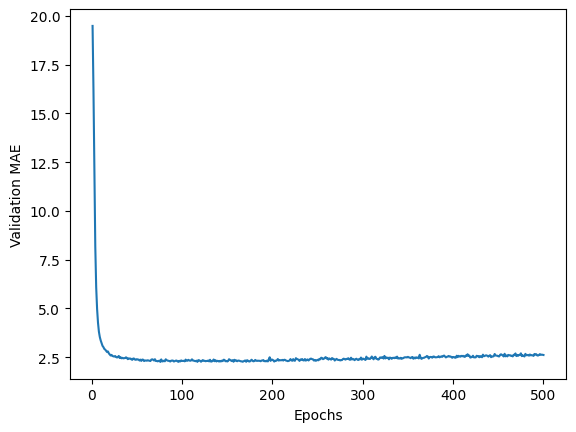

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

### Plotting validation scores, excluding the first 10 data points
It may be a little difficult to read the plot, due to a scaling issue: the validation MAE for the first few epochs is dramatically higher than the values that follow.

Let’s omit the first 10 data points, which are on a different scale than the rest of the curve.

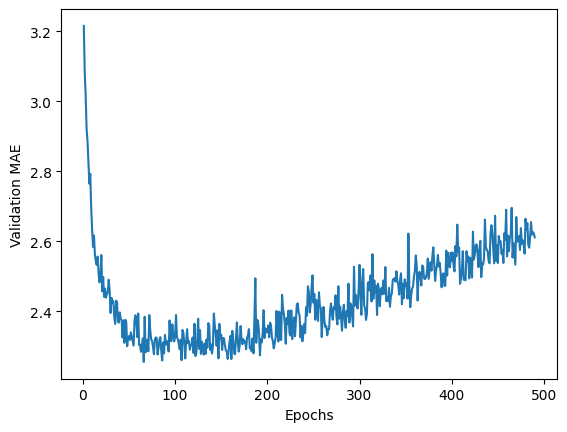

In [16]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

As we can see the validation MAE stops improving significantly after 120-140 epochs. Past that point, we start overfitting.

### Training the final model

In [19]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=140, batch_size=8, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.3749 - mae: 2.1443 


In [20]:
test_mae_score

2.342031955718994

## Generating predictions on new data
With this scalar regression model, ```predict()``` returns the model’s guess for the sample’s price in thousands of dollars:

In [24]:
predictions = model.predict(test_data)
predictions[1]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


array([18.636715], dtype=float32)

In [23]:
test_targets[1]

np.float64(18.8)

The second house in the test set is predicted to have a price of $ $18,636$, while its true value is $ $18,800$. Our model made a minimal error of less than $ $200$ !